In [17]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.utils import save_image
from PIL import Image
import numpy as np
import os
from matplotlib.pyplot import imshow, imsave


In [18]:
MODEL_NAME = 'TerrainGAN'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DATA_PATH = r"C:\Users\mshestopalov\PycharmProjects\procedural-terrain-generation\data\processed_dataset"
BATCH_SIZE = 64
IMAGE_SIZE = 128
N_NOISE = 100
MAX_EPOCH = 50
N_CRITIC = 2  # discriminator steps per generator step

print(DEVICE)


cuda


In [19]:
def get_sample_image(G, n_noise):
    z = torch.randn(100, n_noise).to(DEVICE)
    y_hat = G(z).view(100, IMAGE_SIZE, IMAGE_SIZE)
    result = y_hat.cpu().data.numpy()
    img = np.zeros([IMAGE_SIZE*10, IMAGE_SIZE*10])
    for j in range(10):
        img[j*IMAGE_SIZE:(j+1)*IMAGE_SIZE] = np.concatenate([x for x in result[j*10:(j+1)*10]], axis=-1)
    return img


In [20]:
class TerrainDataset(Dataset):

    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.img_files = [f for f in os.listdir(root_dir) if f.endswith("_h.png")]

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.img_files[idx])
        image = Image.open(img_path).convert("L")
        if self.transform:
            image = self.transform(image)
        return image


In [21]:
class Discriminator(nn.Module):
    def __init__(self, input_size=IMAGE_SIZE*IMAGE_SIZE):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.model(x)

class Generator(nn.Module):
    def __init__(self, input_size=100, output_size=IMAGE_SIZE*IMAGE_SIZE):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, output_size),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.model(x)
        return x.view(x.size(0), 1, IMAGE_SIZE, IMAGE_SIZE)


In [22]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = TerrainDataset(root_dir=DATA_PATH, transform=transform)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)


In [23]:
D = Discriminator().to(DEVICE)
G = Generator(N_NOISE).to(DEVICE)

criterion = nn.BCELoss()
D_opt = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
G_opt = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Labels
real_labels = torch.ones(BATCH_SIZE, 1).to(DEVICE)
fake_labels = torch.zeros(BATCH_SIZE, 1).to(DEVICE)

# Create samples folder
os.makedirs('samples', exist_ok=True)


In [24]:
step = 0
for epoch in range(MAX_EPOCH):
    for images in dataloader:
        images = images.to(DEVICE)

        # --- Train Discriminator ---
        D_real = D(images)
        D_real_loss = criterion(D_real, real_labels)

        z = torch.randn(BATCH_SIZE, N_NOISE).to(DEVICE)
        D_fake = D(G(z))
        D_fake_loss = criterion(D_fake, fake_labels)

        D_loss = D_real_loss + D_fake_loss
        D.zero_grad()
        D_loss.backward()
        D_opt.step()

        # --- Train Generator ---
        if step % N_CRITIC == 0:
            z = torch.randn(BATCH_SIZE, N_NOISE).to(DEVICE)
            G_fake = D(G(z))
            G_loss = criterion(G_fake, real_labels)

            G.zero_grad()
            G_loss.backward()
            G_opt.step()

        # Logging
        if step % 500 == 0:
            print(f"Epoch [{epoch}/{MAX_EPOCH}], Step {step}, D Loss: {D_loss.item():.4f}, G Loss: {G_loss.item():.4f}")

        # Save sample images
        if step % 1000 == 0:
            G.eval()
            img = get_sample_image(G, N_NOISE)
            imsave(f'samples/{MODEL_NAME}_step{step:03d}.jpg', img, cmap='gray')
            G.train()

        step += 1


Epoch [0/50], Step 0, D Loss: 1.3713, G Loss: 0.9422
Epoch [0/50], Step 500, D Loss: 0.4830, G Loss: 4.3796
Epoch [0/50], Step 1000, D Loss: 0.4866, G Loss: 2.3114
Epoch [0/50], Step 1500, D Loss: 0.4825, G Loss: 2.1967
Epoch [1/50], Step 2000, D Loss: 0.4801, G Loss: 2.3695
Epoch [1/50], Step 2500, D Loss: 0.4836, G Loss: 2.1042
Epoch [1/50], Step 3000, D Loss: 0.7358, G Loss: 2.0930
Epoch [1/50], Step 3500, D Loss: 1.0418, G Loss: 1.5835
Epoch [2/50], Step 4000, D Loss: 0.9040, G Loss: 1.4686
Epoch [2/50], Step 4500, D Loss: 0.9916, G Loss: 1.2113
Epoch [2/50], Step 5000, D Loss: 0.9241, G Loss: 1.5374
Epoch [2/50], Step 5500, D Loss: 1.0621, G Loss: 1.7036
Epoch [3/50], Step 6000, D Loss: 1.1228, G Loss: 1.5988
Epoch [3/50], Step 6500, D Loss: 1.0823, G Loss: 1.4175
Epoch [3/50], Step 7000, D Loss: 1.1839, G Loss: 1.2127
Epoch [3/50], Step 7500, D Loss: 1.0962, G Loss: 1.1278
Epoch [4/50], Step 8000, D Loss: 1.0078, G Loss: 1.2853
Epoch [4/50], Step 8500, D Loss: 1.1587, G Loss: 1.3

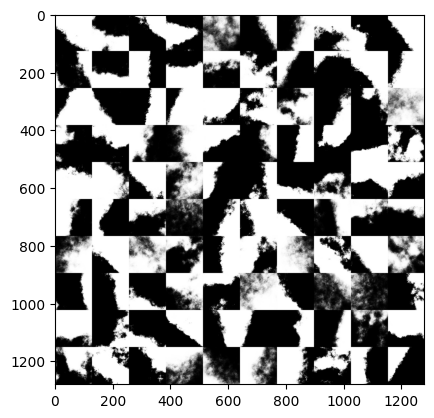

In [25]:
G.eval()
imshow(get_sample_image(G, N_NOISE), cmap='gray')


In [26]:
torch.save(D.state_dict(), 'D.pkl')
torch.save(G.state_dict(), 'G.pkl')
